In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [37]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'],nrows=1000)

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 4  Estou contente com a compra entrega rápida o ú...
1                 4  Por apenas R$1994.20,eu consegui comprar esse ...
2                 4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                 4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                 5  A entrega foi no prazo, as americanas estão de...
..              ...                                                ...
995               4  ASUS surpreendeu pela câmera de alta resolução...
996               3  TV show de bola! Tem aplicativos para entrada ...
997               1  Primeiro. Venderam um produto que não tinha no...
998               3  Produto bom entrega rápida gostei e recomendo ...
999               5  Recebi no prazo prometido. Muito bem embalado ...

[1000 rows x 2 columns]>


In [38]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [39]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [40]:
print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 4  contente compra entrega rapida unico problema ...
1                 4        apenas consegui comprar lindo copo acrilico
2                 4  supera agilidade praticidade outras panelas el...
3                 4          filho amou parece verdade tantos detalhes
4                 5  entrega prazo americanas estao parabens smart ...
..              ...                                                ...
995               4  asus surpreendeu camera alta resolucao embelez...
996               3  tv show bola aplicativos entrada youtube twitt...
997               1  primeiro venderam produto nao estoque segundo ...
998               3  produto bom entrega rapida gostei recomendo po...
999               5  recebi prazo prometido bem embalado satisfeito...

[1000 rows x 2 columns]>


In [41]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    194
2     46
3    115
4    262
5    383
Name: overall_rating, dtype: int64

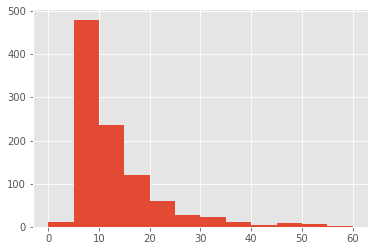

991


In [42]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [43]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 1  comprei base ja faz mes pagamento aprovado ate...
1                 3  produto bom qualidade excelente quer maquina q...
2                 2  produto fraco facil quebrar acabamento muitas ...
3                 4  vendo celular televisao geladeira grana havia ...
4                 4         bom interessante som iluminacao agradaveis
..              ...                                                ...
995               4  adorei recomendo todos perfeita protecao moto ...
996               5  adorei recomendo falar entrega bem rapida ante...
997               4  recomendo produto acordo anunciado entrega rap...
998               3  produto entregue prazo prometido funcionando n...
999               5  ropo cumpre promete deve dar muita atencao uso...

[1000 rows x 2 columns]>


In [44]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [45]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [46]:
b2wCorpus.shape

(1000, 3)

In [47]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 5].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [48]:
b2wCorpus.shape

(972, 3)

In [49]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [50]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,1,"[9735, 252, 12783, 234, 25236, 1101, 2217, 188...",46
1,3,"[902, 226, 532, 2104, 185, 45326, 532]",7
2,2,"[902, 4916, 54465, 5158, 12871, 388, 122859, 7...",13
3,4,"[3478, 2989, 0, 15378, 12499, 315, 81443, 4644...",11
4,4,"[226, 2722, 1681, 0, 0]",5


In [51]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [52]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [53]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,1,"[9735, 252, 12783, 234, 25236, 1101, 2217, 188...",46
1,3,"[902, 226, 532, 2104, 185, 45326, 532, 0, 0, 0...",7
2,2,"[902, 4916, 54465, 5158, 12871, 388, 122859, 7...",13
3,4,"[3478, 2989, 0, 15378, 12499, 315, 81443, 4644...",11
4,4,"[226, 2722, 1681, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",5


In [54]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [55]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [56]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
903,3,"[0, 1481, 226, 7804, 902, 209, 566, 2499, 7804...",50
301,1,"[9735, 3223, 1100, 117, 12783, 315, 8201, 2610...",49
594,1,"[7051, 0, 86, 18874, 141, 7804, 428, 14468, 20...",49
670,2,"[7804, 5973, 5437, 7804, 185, 509, 7288, 439, ...",47
0,1,"[9735, 252, 12783, 234, 25236, 1101, 2217, 188...",46


In [57]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of      overall_rating                                        review_text  ord
829               4  [20017, 1118, 363, 4104, 343, 635, 1108, 672, ...   46
147               1  [902, 7804, 978, 532, 138589, 2648, 5841, 7804...   46
762               2  [3006, 1118, 678, 0, 1234, 193, 3460, 27023, 7...   42
651               5  [101071, 902, 16751, 439, 1664, 4792, 59111, 1...   35
951               5  [2499, 321, 566, 902, 532, 6376, 678, 0, 0, 70...   31
..              ...                                                ...  ...
942               4  [101071, 902, 2424, 70, 62443, 0, 0, 0, 0, 0, ...    5
8                 3  [0, 2832, 902, 117, 274, 0, 0, 0, 0, 0, 0, 0, ...    5
949               3  [902, 226, 15475, 930, 8804, 0, 0, 0, 0, 0, 0,...    5
452               4  [226, 122, 340, 22522, 2294, 0, 0, 0, 0, 0, 0,...    5
892               5  [902, 112, 2009, 2905, 114, 0, 0, 0, 0, 0, 0, ...    5

[97 rows x 3 columns]>

In [58]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of      overall_rating                                        review_text  ord
952               1  [9735, 902, 428, 566, 17382, 930, 2009, 902, 3...   50
724               5  [950, 1069, 19328, 1087, 187622, 42542, 1713, ...   48
458               2  [902, 363, 532, 17382, 930, 8766, 32617, 46754...   42
592               3  [226, 86, 377, 411, 18874, 0, 902, 17382, 2259...   39
738               4  [245, 2294, 6451, 168, 8308, 7458, 7804, 7186,...   38
..              ...                                                ...  ...
612               5  [3615, 532, 7663, 2499, 2104, 0, 0, 0, 0, 0, 0...    5
502               5  [226, 3013, 566, 12228, 902, 0, 0, 0, 0, 0, 0,...    5
64                3  [1143, 0, 2905, 411, 902, 0, 0, 0, 0, 0, 0, 0,...    5
138               3  [902, 12559, 70, 133577, 2722, 0, 0, 0, 0, 0, ...    5
698               5  [902, 532, 63936, 631, 4035, 0, 0, 0, 0, 0, 0,...    5

[244 rows x 3 columns]>

In [59]:
# Treino, Validação e teste

x = b2wCorpus[['review_text']].values
y = b2wCorpus[['overall_rating']].values

print((b2wCorpus.overall_rating.value_counts()/ b2wCorpus.shape[0]).sort_index())

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
#Tokenizando
vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)

1    0.188272
2    0.046296
3    0.114198
4    0.264403
5    0.386831
Name: overall_rating, dtype: float64


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).